In [33]:
import pandas as pd
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
# Cargar los datos
data = pd.read_csv(r'C:\Users\pc-admin\Documents\Proyectos Data\Customer_Satisfaction\Encuesta.csv')
data


,Unnamed: 0,Gender,customer_type,age,type_of_travel,customer_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,...,inflight_entertainment,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,39463,Female,disloyal Customer,46,Business travel,Eco,406,3,0,4,...,5,1,5,4,2,4,5,0,17.0,neutral or dissatisfied
1,39464,Male,Loyal Customer,24,Business travel,Eco,479,4,3,3,...,4,2,2,1,4,1,4,0,0.0,neutral or dissatisfied
2,39467,Male,Loyal Customer,63,Business travel,Business,2009,2,3,3,...,2,2,2,2,3,2,2,0,30.0,neutral or dissatisfied
3,39470,Male,Loyal Customer,38,Business travel,Business,1984,1,4,5,...,1,1,2,1,1,1,4,2,0.0,neutral or dissatisfied
4,39471,Female,Loyal Customer,35,Personal Travel,Eco,2288,1,3,2,...,3,2,1,4,2,4,3,0,0.0,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71887,129875,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
71888,129876,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
71889,129877,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
71890,129878,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


In [35]:
# Calcular el total de filas
total_filas = len(data)

# Identificar y mostrar valores nulos junto con su porcentaje correspondiente
valores_nulos = data.isnull().sum()
porcentaje_nulos = (valores_nulos / total_filas) * 100

# Crear un DataFrame para mostrar ambos resultados
nulos_df = pd.DataFrame({
    'Valores Nulos': valores_nulos,
    'Porcentaje Nulos (%)': porcentaje_nulos
})

# Imprimir el resumen de valores nulos
print("Valores nulos y su porcentaje por columna:")
print(nulos_df)

# Manejo de los valores nulos basado en el porcentaje
for columna, porcentaje in porcentaje_nulos.items():
    if porcentaje > 0:  # Si la columna tiene valores nulos
        if porcentaje <= 0.5:
            # Eliminar filas con valores nulos si el porcentaje es menor o igual a 0.5%
            data = data.dropna(subset=[columna])
            print(f"Filas con valores nulos en '{columna}' eliminadas.")
        else:
            # Imputar valores nulos con la mediana de los últimos 10 registros si el porcentaje es mayor a 0.5%
            median_columna = data[columna].dropna().tail(10).median()
            if pd.api.types.is_integer_dtype(data[columna]):
                median_columna = int(median_columna)  # Asegurarnos de que la mediana sea un entero si corresponde
            data[columna] = data[columna].fillna(median_columna)
            print(f"Valores nulos en '{columna}' imputados con la mediana de los últimos 10 registros.")


Valores nulos y su porcentaje por columna:
                                   Valores Nulos  Porcentaje Nulos (%)
Unnamed: 0                                     0              0.000000
Gender                                         0              0.000000
customer_type                                  0              0.000000
age                                            0              0.000000
type_of_travel                                 0              0.000000
customer_class                                 0              0.000000
flight_distance                                0              0.000000
inflight_wifi_service                          0              0.000000
departure_arrival_time_convenient              0              0.000000
ease_of_online_booking                         0              0.000000
gate_location                                  0              0.000000
food_and_drink                                 0              0.000000
online_boarding                   

In [36]:
data = data.drop('Unnamed: 0', axis=1)


In [37]:
# Codificación de Variables Categóricas y Conversión de Tipos
# Codificar las variables categóricas usando One-Hot Encoding, incluyendo la columna 'satisfaction'
data['satisfaction'] = data['satisfaction'].apply(lambda x: 1 if x.strip() == 'satisfied' else 0)
data = pd.get_dummies(data, columns=['Gender', 'customer_type', 'type_of_travel', 'customer_class'], drop_first=True)

# Convertir columnas booleanas a números (0 y 1) usando apply y map
data = data.apply(lambda col: col.map({True: 1, False: 0}) if col.dtype == 'bool' else col)

# Asegurar la consistencia de tipos de datos numéricos
# Convertir todas las columnas numéricas optimizadas a tipos estándar y asegurar que sean numéricas
columnas_numericas = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
data[columnas_numericas] = data[columnas_numericas].apply(pd.to_numeric, downcast='integer')

# Verificación y Validación
# Verificar la estructura final del DataFrame
print("\nEstructura final del DataFrame después de todas las transformaciones:")
print(data.info())



Estructura final del DataFrame después de todas las transformaciones:
<class 'pandas.core.frame.DataFrame'>
Index: 71676 entries, 0 to 71891
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                71676 non-null  int8 
 1   flight_distance                    71676 non-null  int16
 2   inflight_wifi_service              71676 non-null  int8 
 3   departure_arrival_time_convenient  71676 non-null  int8 
 4   ease_of_online_booking             71676 non-null  int8 
 5   gate_location                      71676 non-null  int8 
 6   food_and_drink                     71676 non-null  int8 
 7   online_boarding                    71676 non-null  int8 
 8   seat_comfort                       71676 non-null  int8 
 9   inflight_entertainment             71676 non-null  int8 
 10  onboard_service                    71676 non-null  int8 
 11  leg_room_servi

In [38]:
# Verificar que 'satisfaction' esté correctamente codificada y que solo tenga valores 0 y 1
print("\nVerificación de la columna 'satisfaction':")
print(data['satisfaction'].unique())

# Verificar la distribución de las variables categóricas codificadas
for col in ['Gender_Male', 'customer_type_disloyal Customer', 'type_of_travel_Personal Travel', 'customer_class_Eco', 'customer_class_Eco Plus']:
    print(f"Distribución de valores en '{col}':")
    print(data[col].value_counts())
    print("\n")


Verificación de la columna 'satisfaction':
[0 1]
Distribución de valores en 'Gender_Male':
Gender_Male
0    36285
1    35391
Name: count, dtype: int64


Distribución de valores en 'customer_type_disloyal Customer':
customer_type_disloyal Customer
0    58375
1    13301
Name: count, dtype: int64


Distribución de valores en 'type_of_travel_Personal Travel':
type_of_travel_Personal Travel
0    48848
1    22828
Name: count, dtype: int64


Distribución de valores en 'customer_class_Eco':
customer_class_Eco
0    38787
1    32889
Name: count, dtype: int64


Distribución de valores en 'customer_class_Eco Plus':
customer_class_Eco Plus
0    66428
1     5248
Name: count, dtype: int64




In [39]:
# Preparación para Análisis de Multicolinealidad
# Seleccionar solo las columnas numéricas para el cálculo del VIF
columnas_numericas = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

# Verificar las columnas que fueron seleccionadas
print("Columnas seleccionadas como numéricas para el VIF:")
print(columnas_numericas.columns)

Columnas seleccionadas como numéricas para el VIF:
Index(['age', 'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'onboard_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction', 'Gender_Male', 'customer_type_disloyal Customer',
       'type_of_travel_Personal Travel', 'customer_class_Eco',
       'customer_class_Eco Plus'],
      dtype='object')


In [40]:
# Definir las columnas categóricas originales que se transformaron
categorical_original = ['Gender', 'customer_type', 'type_of_travel', 'customer_class', 'satisfaction']

# Columnas actuales después de la transformación
current_columns = data.dtypes

# Identificar columnas que podrían haber sido dummies
potential_dummies = current_columns[current_columns == 'int8'].index.tolist()

# Imprimir las columnas categóricas originales y sus correspondientes dummies
print("Columnas categóricas originales y las dummies creadas:")

# Crear un diccionario para mapear las categorías originales con sus dummies
dummy_mapping = {
    'Gender': ['Gender_Male'],
    'customer_type': ['customer_type_disloyal Customer'],
    'type_of_travel': ['type_of_travel_Personal Travel'],
    'customer_class': ['customer_class_Eco', 'customer_class_Eco Plus'],
    'satisfaction': ['satisfaction']
}

# Verificar si las dummies creadas están en el DataFrame
for original_column, dummies in dummy_mapping.items():
    print(f"\nCategoría original: '{original_column}'")
    for dummy in dummies:
        if dummy in potential_dummies:
            print(f"  - Columna dummy '{dummy}' creada correctamente.")
        else:
            print(f"  - Columna dummy '{dummy}' NO encontrada o no es un 'int8'.")

# Verificar que no haya columnas que eran categóricas y no fueron transformadas correctamente
print("\nColumnas categóricas originales que no fueron transformadas o están ausentes en el mapeo:")
for col in categorical_original:
    if not any(dummy.startswith(col) for dummy in potential_dummies):
        print(f"  - {col} NO fue transformada correctamente.")


Columnas categóricas originales y las dummies creadas:

Categoría original: 'Gender'
  - Columna dummy 'Gender_Male' creada correctamente.

Categoría original: 'customer_type'
  - Columna dummy 'customer_type_disloyal Customer' creada correctamente.

Categoría original: 'type_of_travel'
  - Columna dummy 'type_of_travel_Personal Travel' creada correctamente.

Categoría original: 'customer_class'
  - Columna dummy 'customer_class_Eco' creada correctamente.
  - Columna dummy 'customer_class_Eco Plus' creada correctamente.

Categoría original: 'satisfaction'
  - Columna dummy 'satisfaction' creada correctamente.

Columnas categóricas originales que no fueron transformadas o están ausentes en el mapeo:


In [41]:
data.var()

age                                     231.476062
flight_distance                      983845.192820
inflight_wifi_service                     1.724087
departure_arrival_time_convenient         2.323905
ease_of_online_booking                    1.943858
gate_location                             1.620388
food_and_drink                            1.770777
online_boarding                           1.816075
seat_comfort                              1.745313
inflight_entertainment                    1.792907
onboard_service                           1.660436
leg_room_service                          1.739820
baggage_handling                          1.392524
checkin_service                           1.609169
inflight_service                          1.387272
cleanliness                               1.733875
departure_delay_in_minutes             1443.773839
arrival_delay_in_minutes               1482.365447
satisfaction                              0.242095
Gender_Male                    

In [42]:
# Definir una función para eliminar outliers y contar cuántos se eliminaron
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Contar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    count_outliers = len(outliers)
    # Eliminar los outliers
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean, count_outliers

# Aplicar la función a las columnas con outliers y registrar cuántos se eliminan
columns_to_clean = ['flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
outliers_removed = {}

# Iniciar con el DataFrame original
data_clean = data.copy()

for col in columns_to_clean:
    data_clean, num_outliers = remove_outliers(data_clean, col)
    outliers_removed[col] = num_outliers

# Verificar la eliminación de outliers
print("Tamaño original del DataFrame:", data.shape)
print("Tamaño del DataFrame después de eliminar outliers:", data_clean.shape)

# Mostrar la cantidad de outliers eliminados por variable
for col, count in outliers_removed.items():
    print(f"Outliers eliminados en '{col}': {count}")



Tamaño original del DataFrame: (71676, 24)
Tamaño del DataFrame después de eliminar outliers: (51855, 24)
Outliers eliminados en 'flight_distance': 1794
Outliers eliminados en 'departure_delay_in_minutes': 9723
Outliers eliminados en 'arrival_delay_in_minutes': 8304


In [43]:
data_clean.var()

age                                     233.534797
flight_distance                      825050.292592
inflight_wifi_service                     1.761742
departure_arrival_time_convenient         2.352823
ease_of_online_booking                    1.958021
gate_location                             1.625013
food_and_drink                            1.764881
online_boarding                           1.828238
seat_comfort                              1.748078
inflight_entertainment                    1.798292
onboard_service                           1.661478
leg_room_service                          1.755778
baggage_handling                          1.404563
checkin_service                           1.602095
inflight_service                          1.383505
cleanliness                               1.728929
departure_delay_in_minutes               23.674005
arrival_delay_in_minutes                  8.857601
satisfaction                              0.244746
Gender_Male                    

In [44]:
# Verificación de la estructura final del DataFrame
print("\nEstructura final del DataFrame después de todas las transformaciones:")
print(data_clean.info())

# Verificación de la codificación correcta de la columna 'satisfaction'
print("\nVerificación de la columna 'satisfaction':")
print(data_clean['satisfaction'].unique())



Estructura final del DataFrame después de todas las transformaciones:
<class 'pandas.core.frame.DataFrame'>
Index: 51855 entries, 1 to 71891
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                51855 non-null  int8 
 1   flight_distance                    51855 non-null  int16
 2   inflight_wifi_service              51855 non-null  int8 
 3   departure_arrival_time_convenient  51855 non-null  int8 
 4   ease_of_online_booking             51855 non-null  int8 
 5   gate_location                      51855 non-null  int8 
 6   food_and_drink                     51855 non-null  int8 
 7   online_boarding                    51855 non-null  int8 
 8   seat_comfort                       51855 non-null  int8 
 9   inflight_entertainment             51855 non-null  int8 
 10  onboard_service                    51855 non-null  int8 
 11  leg_room_servi

Número de columnas en X antes de SMOTE: 23
Número de columnas en X_balanced después de SMOTE: 23
satisfaction
0    29688
1    29688
Name: count, dtype: int64


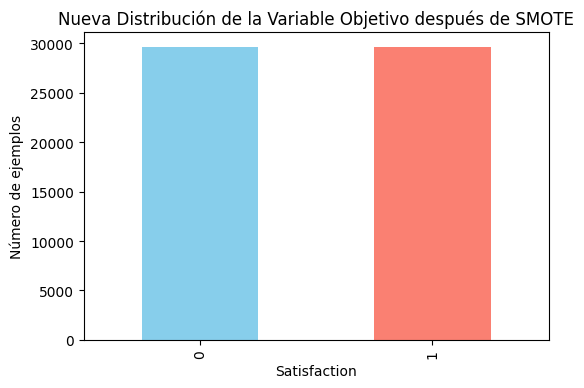

In [45]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd

# Separar características y la variable objetivo
X = data_clean.drop(columns=['satisfaction'])  # Todas las columnas menos 'satisfaction'
y = data_clean['satisfaction']  # La columna 'satisfaction'

# Verificar el número de columnas antes de aplicar SMOTE
print(f"Número de columnas en X antes de SMOTE: {X.shape[1]}")

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Verificar el número de columnas después de aplicar SMOTE
print(f"Número de columnas en X_balanced después de SMOTE: {X_balanced.shape[1]}")

# Convertir X_balanced a un DataFrame para mantener las etiquetas de las columnas
X_balanced_df = pd.DataFrame(X_balanced, columns=X.columns)

# Añadir la columna de la variable objetivo 'satisfaction'
data_balanced = X_balanced_df.copy()
data_balanced['satisfaction'] = y_balanced

# Verificar la nueva distribución de la variable objetivo
nueva_distribucion = y_balanced.value_counts()
print(nueva_distribucion)

# Visualizar la nueva distribución
plt.figure(figsize=(6, 4))
nueva_distribucion.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Nueva Distribución de la Variable Objetivo después de SMOTE')
plt.xlabel('Satisfaction')
plt.ylabel('Número de ejemplos')
plt.show()

In [46]:
# Añadir una constante al conjunto de datos
X = add_constant(data_balanced)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Eliminar el VIF para la constante
vif_data = vif_data[vif_data.Variable != 'const']

# Filtrar las variables con un VIF mayor a 4
vif_alto = vif_data[vif_data["VIF"] > 4]

# Guardar los nombres de las columnas que serán eliminadas
columnas_eliminadas = vif_alto["Variable"].tolist()

# Eliminar las columnas correspondientes del DataFrame original
data_balanced = data_clean.drop(columns=columnas_eliminadas)

# Eliminar la columna 'const' del DataFrame
# data_clean = data_clean.drop(columns=['const'])

# Imprimir las variables eliminadas
print("Variables eliminadas debido a VIF alto:")
print(columnas_eliminadas)

# Verificar la estructura del DataFrame después de eliminar las variables
print("\nDataFrame después de eliminar variables con VIF mayor a 4:")
print(data_balanced.info())


Variables eliminadas debido a VIF alto:
['inflight_entertainment']

DataFrame después de eliminar variables con VIF mayor a 4:
<class 'pandas.core.frame.DataFrame'>
Index: 51855 entries, 1 to 71891
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                51855 non-null  int8 
 1   flight_distance                    51855 non-null  int16
 2   inflight_wifi_service              51855 non-null  int8 
 3   departure_arrival_time_convenient  51855 non-null  int8 
 4   ease_of_online_booking             51855 non-null  int8 
 5   gate_location                      51855 non-null  int8 
 6   food_and_drink                     51855 non-null  int8 
 7   online_boarding                    51855 non-null  int8 
 8   seat_comfort                       51855 non-null  int8 
 9   onboard_service                    51855 non-null  int8 
 10  leg_room_service    

In [47]:
# Exportar el DataFrame data_balanced como un archivo CSV
output_path = r'C:\Users\pc-admin\Documents\Proyectos Data\Customer_Satisfaction\data_balanced.csv'
data_balanced.to_csv(output_path, index=False)